**Models with measurement error and data uncertainty in a categorical variable**

Motivation: Can we use uncertainty of a data point and still leverage that in a model?

Example: We have a set of height/weight data but we are uncertain whether some come from a child or an adult (a categorical variable). Can we say we're 30% certain that a data point is an adult and still use that in a model?

Would we use a binomial or a beta distribution for that datapoint?

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import seaborn as sns
import xarray as xr

In [71]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [72]:
def standardize(data):
    return (data - np.mean(data)) / np.std(data)

# Import Howell dataset

In [73]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/Data/'
df = pd.read_csv(DATA_DIR + "Howell1.csv", sep=";", header=0)
df['weight_std'] = standardize(df['weight'])
df.head()

,height,weight,age,male,weight_std
0,151.765,47.825606,63.0,1,0.830633
1,139.700,36.485807,63.0,0,0.059514
2,136.525,31.864838,65.0,0,-0.254717
3,156.845,53.041914,41.0,1,1.185347
4,145.415,41.276872,51.0,0,0.385312


In [74]:
df['adult_true'] = np.where(df['age'] > 18, 1, 0)

Text(0.5, 1.0, 'standardized weight\nwithout child/adult uncertainty')

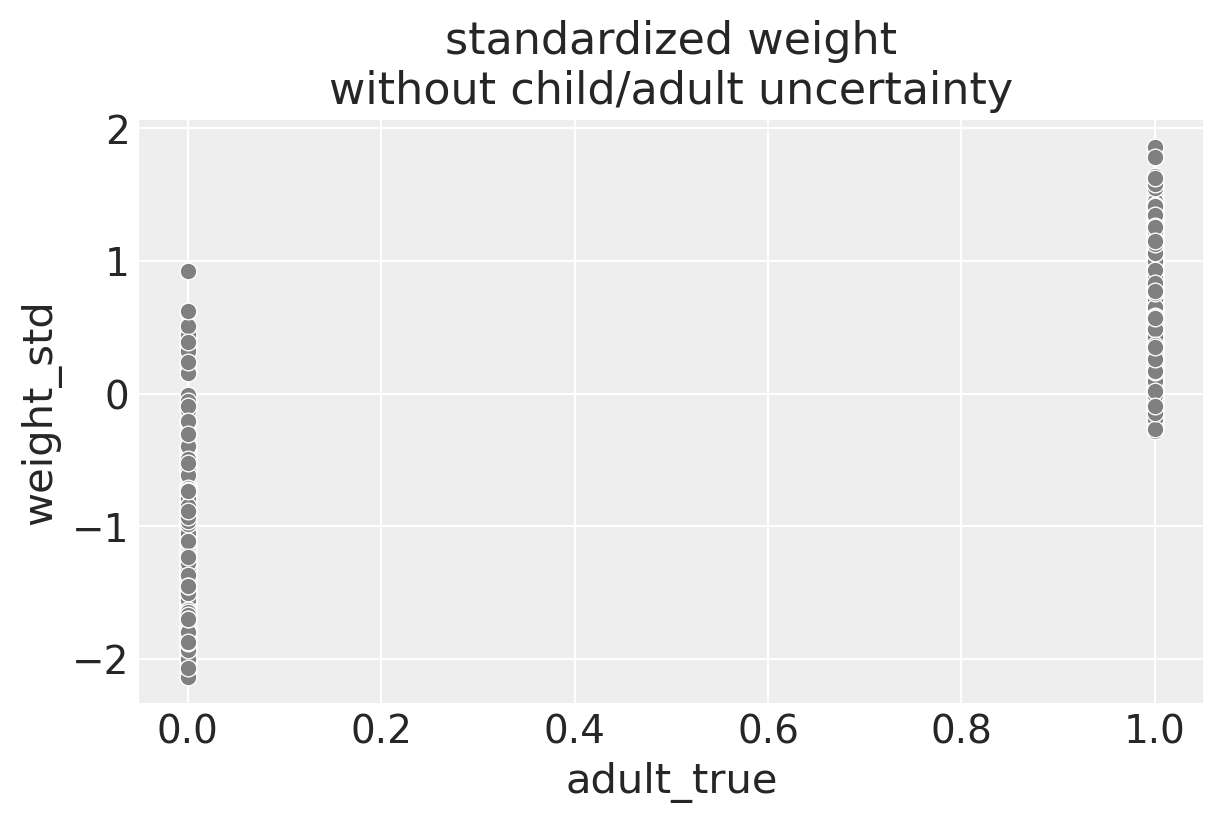

In [77]:
f, ax0 = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(data=df, x="adult_true", y="weight_std", color="gray", ax=ax0)
ax0.set_title('standardized weight\nwithout child/adult uncertainty')

# Create models to estimate the effect of adult status on weight

## Model with known values for child/adult status

$$ W \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu = \alpha + \beta A_{\text{TRUE}}  \tag{coefficient for true status as adult}$$
$$ \alpha \sim \text{Normal}(0, 0.2) $$
$$ \beta \sim \text{Log-Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exp}(1) $$

In [78]:
# model without uncertainty
with pm.Model() as m0:

    a = pm.Normal("a", mu=0, sigma=0.2)
    # using an index variable approach
    b = pm.Lognormal("b", mu=0, sigma=1, shape=2)
    sigma_w = pm.Exponential("sigma", 1)

    # Linear model
    mu = a + b[df['adult_true'].values]

    # Likelihood
    weight = pm.Normal("weight", mu=mu, sigma=sigma_w, observed=df['weight'].values)

    idata_m0 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


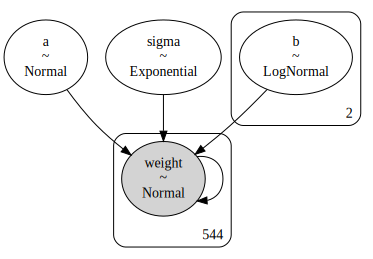

In [79]:
pm.model_to_graphviz(m0)

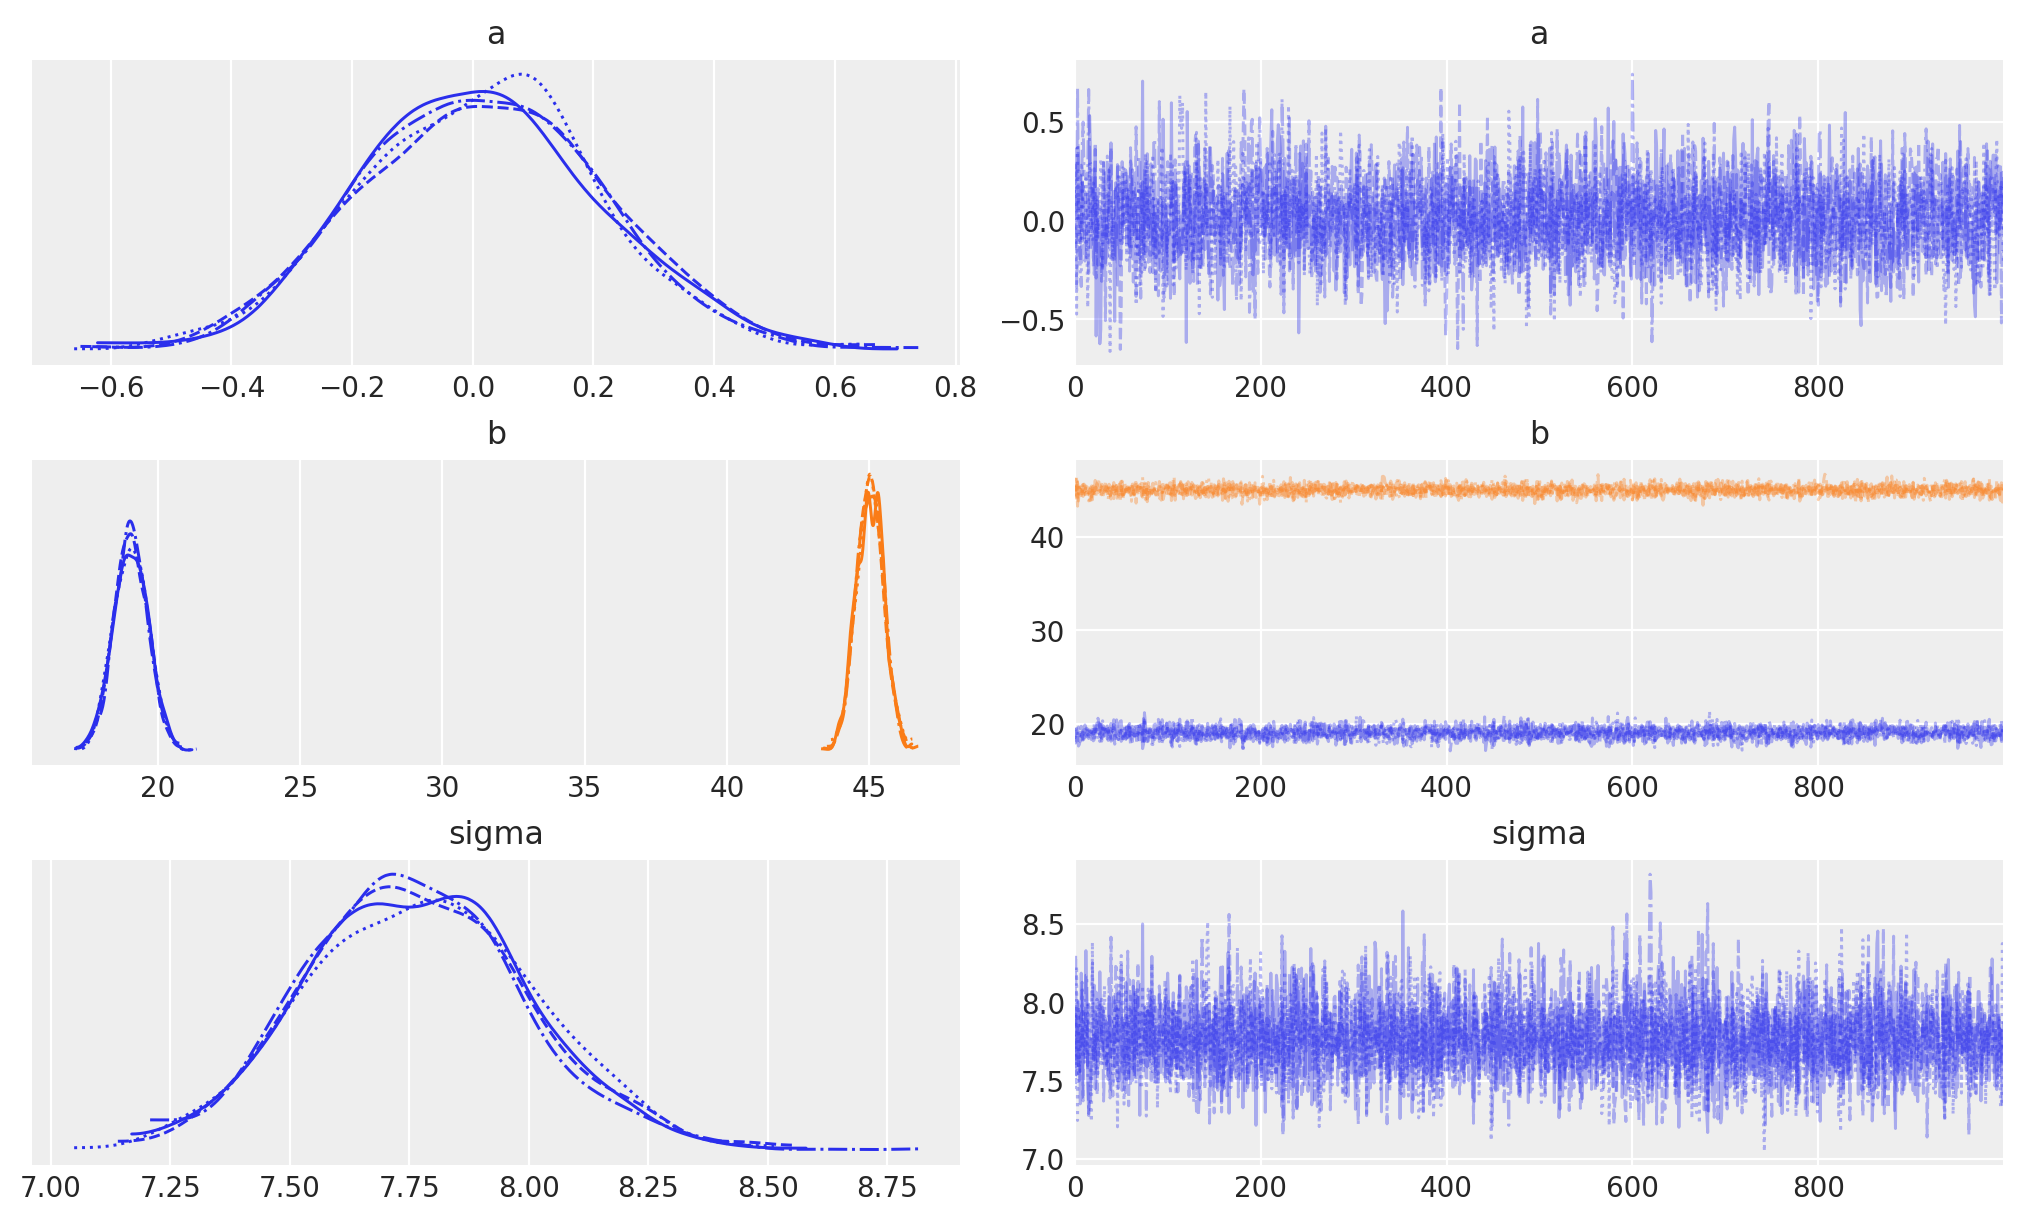

In [80]:
az.plot_trace(idata_m0, figsize=(10, 6));

In [81]:
az.summary(idata_m0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.013,0.201,-0.337,0.403,0.004,0.003,2964.0,2871.0,1.0
b[0],19.050,0.596,17.909,20.156,0.010,0.007,3428.0,2965.0,1.0
b[1],45.027,0.479,44.166,45.953,0.008,0.006,3393.0,3002.0,1.0
sigma,7.768,0.232,7.357,8.226,0.003,0.002,5956.0,2981.0,1.0


## Model with "measurement uncertainty" about child/adult status

$$ W \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu = \alpha + \beta A_{\text{TRUE}}  $$
$$ A_{\text{TRUE}} \sim \text{Bernoulli}(A_{\text{OBS}}) \tag{Atrue is Bernoulli distributed according to Aobs} $$
$$ \alpha \sim \text{Normal}(0, 0.2) $$
$$ \beta \sim \text{Log=Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exp}(1) $$

In [82]:
# Add a child/adult variable where uncertainty is for subjects between 14 and 18

def fill_in_status(row):
    if row['age'] > 18:
        return 1
    elif row['age'] < 14:
        return 0
    else:
        return beta.rvs(a=2, b=2, size=1)[0]

df['adult_obs'] = df.apply(fill_in_status, axis=1)

Text(0.5, 1.0, 'standardized weight\nwith child/adult uncertainty')

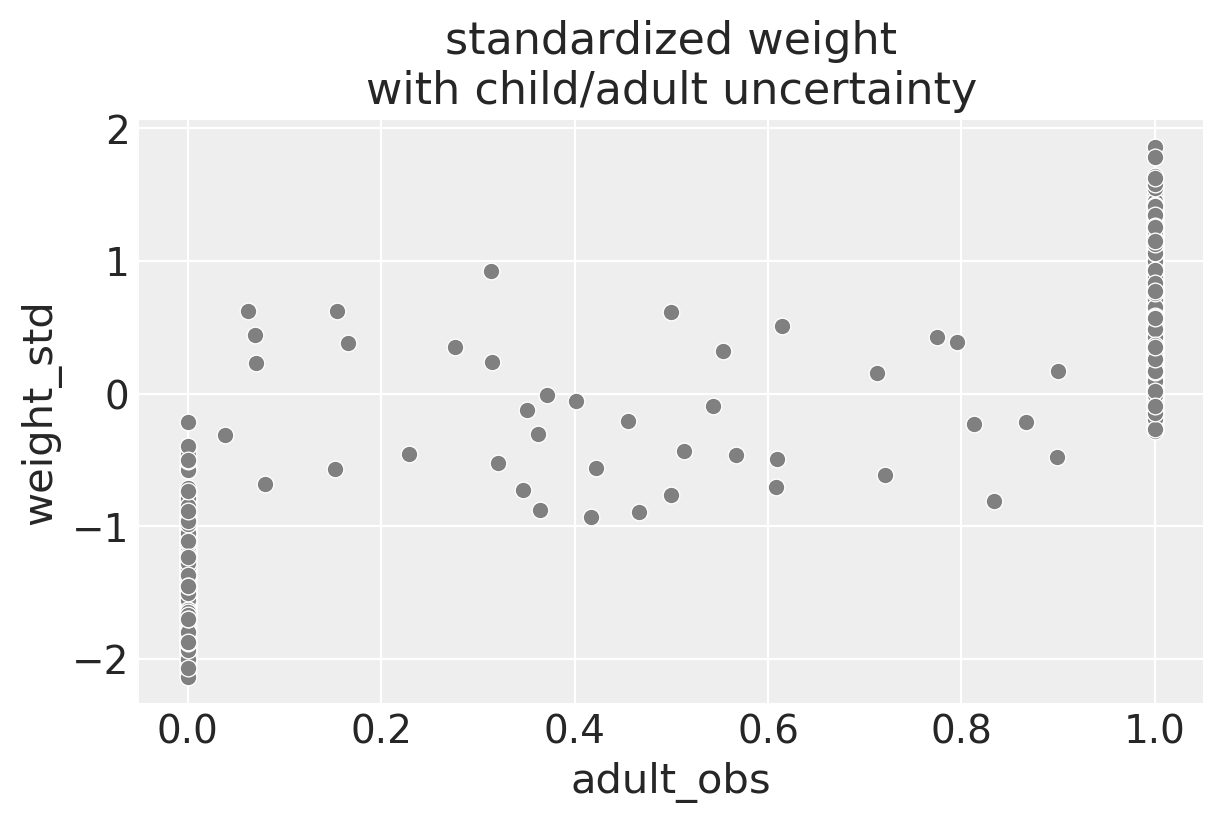

In [84]:
f, ax0 = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(data=df, x="adult_obs", y="weight_std", color="gray", ax=ax0)
ax0.set_title('standardized weight\nwith child/adult uncertainty')

In [85]:
# model with uncertainty
with pm.Model() as m1:

    # get data from the Bernoulli distributed parameter of A_obs
    # the "certain values" remain the same since p will be either 0 or 1
    Atrue = pm.Bernoulli("Atrue", p=df['adult_obs'].values)

    a = pm.Normal("a", mu=0, sigma=0.2)
    # using an index variable approach
    b = pm.Lognormal("b", mu=0, sigma=1, shape=2)
    sigma_w = pm.Exponential("sigma", 1)

    # Linear model
    mu = a + b[Atrue]

    # Likelihood
    weight = pm.Normal("weight", mu=mu, sigma=sigma_w, observed=df['weight'].values)

    idata_m1 = pm.sample(1000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [Atrue]
>NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


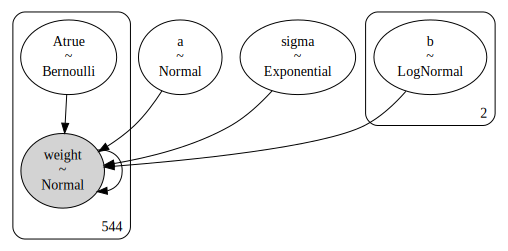

In [86]:
pm.model_to_graphviz(m1)

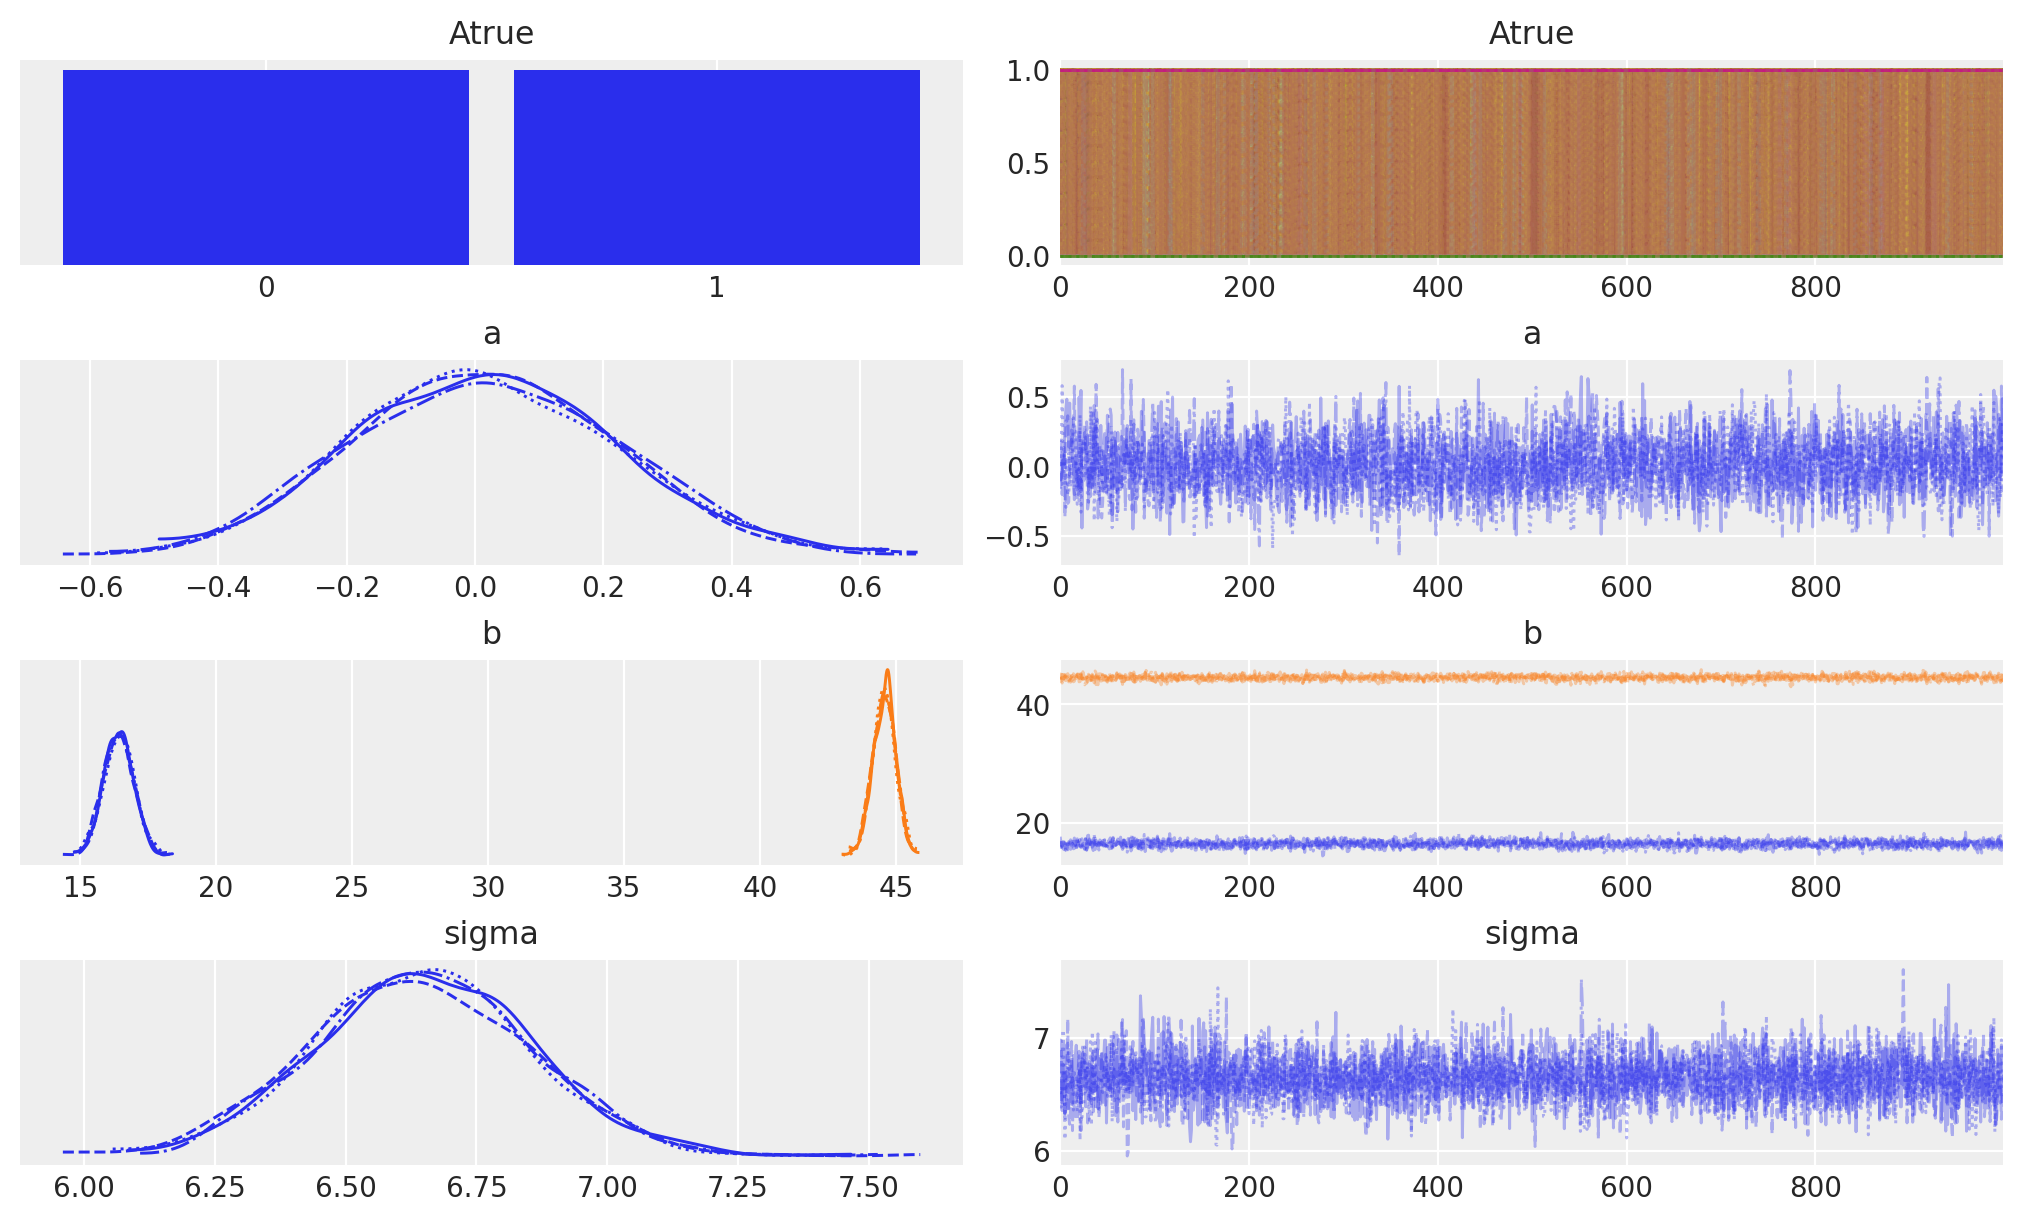

In [87]:
az.plot_trace(idata_m1, figsize=(10, 6));

In [59]:
az.summary(idata_m1, var_names=['a', 'b', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.020,0.206,-0.351,0.415,0.003,0.003,3505.0,3169.0,1.0
b[0],19.049,0.593,17.966,20.158,0.009,0.007,4070.0,3158.0,1.0
b[1],44.997,0.476,44.055,45.832,0.008,0.005,3831.0,2891.0,1.0
sigma,7.769,0.240,7.328,8.209,0.003,0.002,4913.0,3207.0,1.0


## Model with missing values about child/adult status

$$ W \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu = \alpha + \beta A_{\text{TRUE}}  $$
$$ A_{\text{TRUE}} \sim \text{Bernoulli}(A_{\text{OBS}}) \tag{Atrue is Bernoulli distributed according to Aobs} $$
$$ \alpha \sim \text{Normal}(0, 0.2) $$
$$ \beta \sim \text{Log-Normal}(0, 0.5) $$
$$ \sigma \sim \text{Exp}(1) $$

In [98]:
# Add a child/adult variable where uncertainty is for subjects between 14 and 18

def fill_in_status_wmissing(row):
    if row['age'] > 18:
        return 1
    elif row['age'] < 14:
        return 0
    else:
        return None

df['adult_obs_missing'] = df.apply(fill_in_status_wmissing, axis=1)

In [105]:
print("known child/adult status\n",df['adult_obs_missing'].value_counts())
print("\nno. of missing values:", df['adult_obs_missing'].isna().sum())

known child/adult status
 1.0    346
0.0    157
Name: adult_obs_missing, dtype: int64

no. of missing values: 41


# Animation

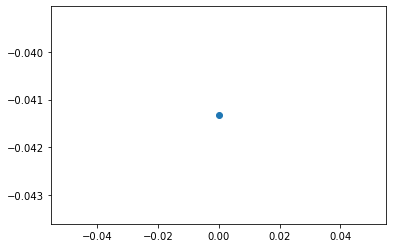

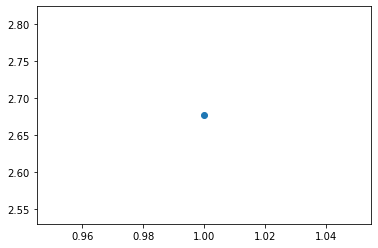

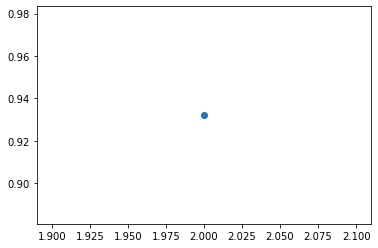

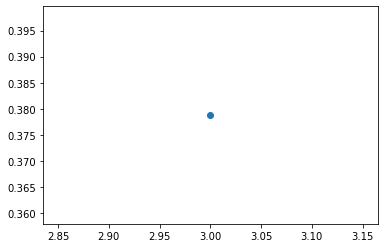

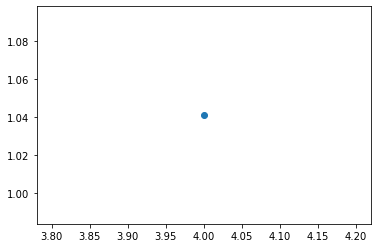

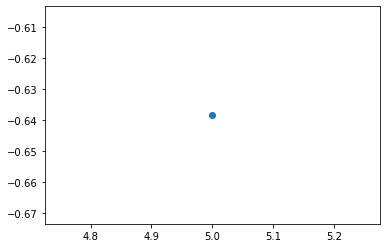

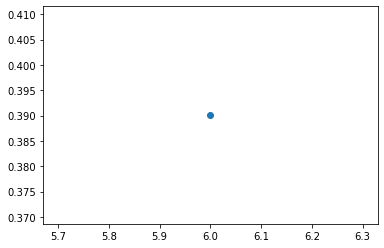

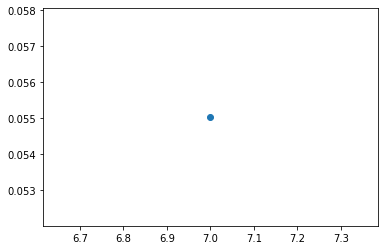

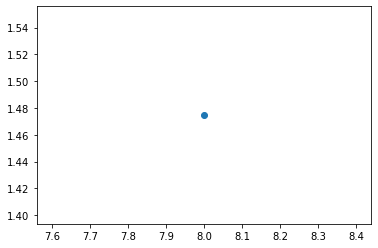

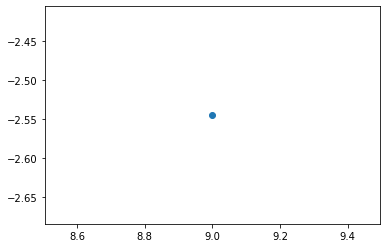

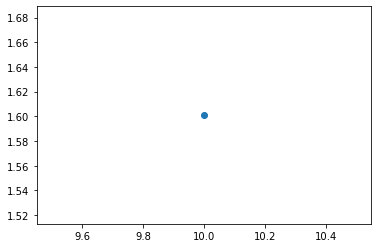

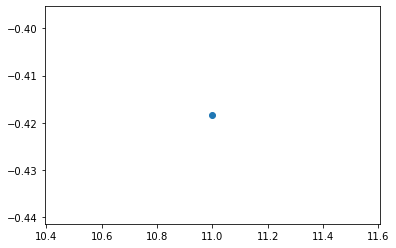

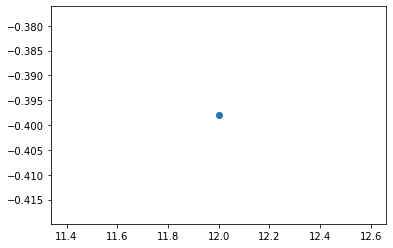

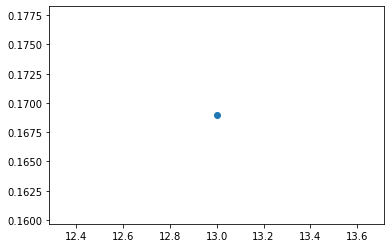

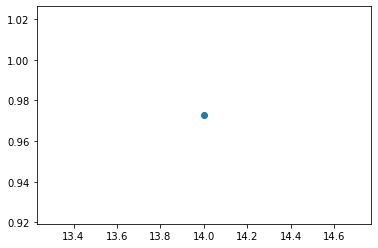

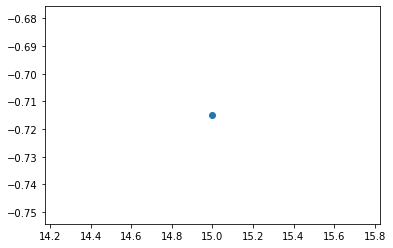

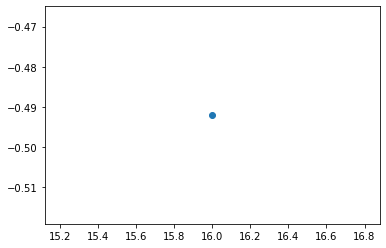

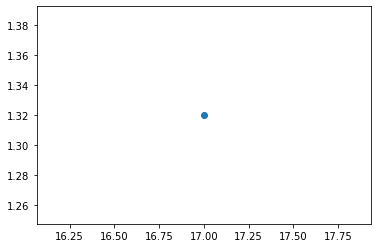

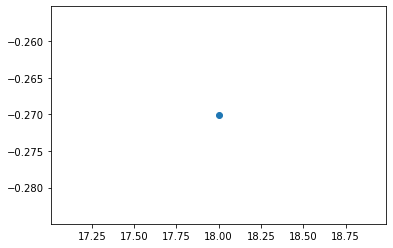

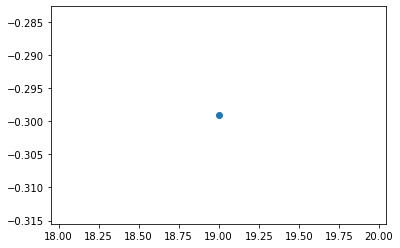

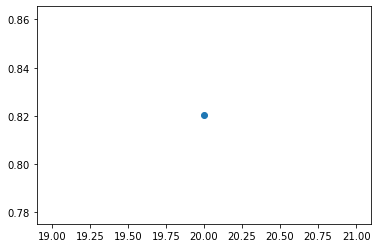

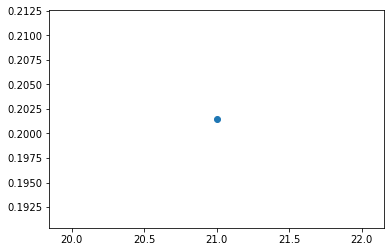

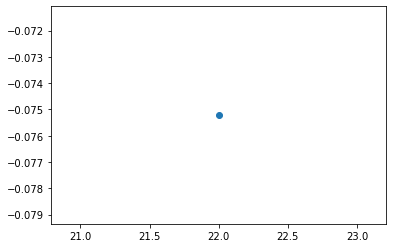

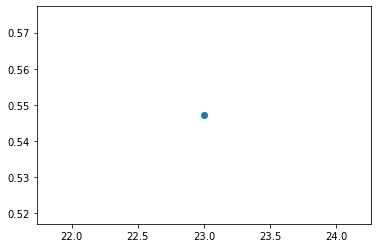

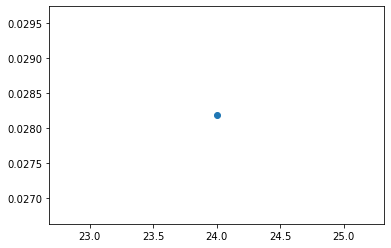

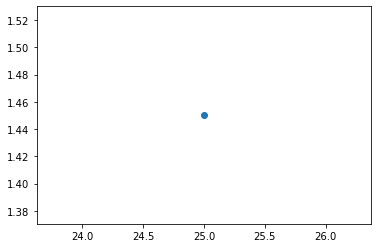

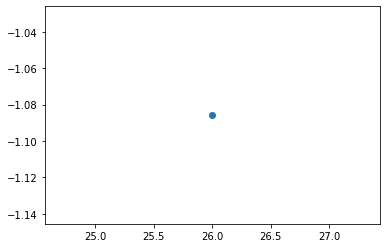

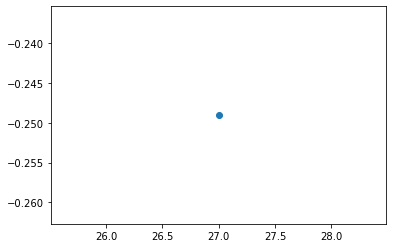

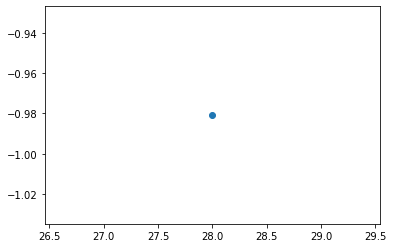

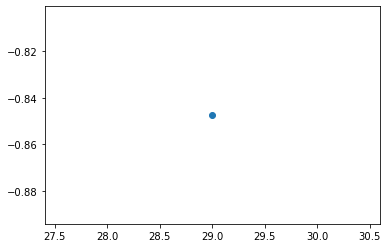

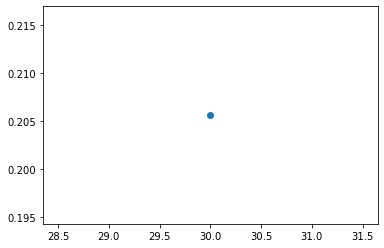

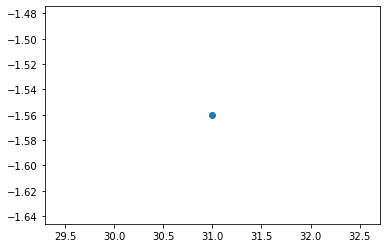

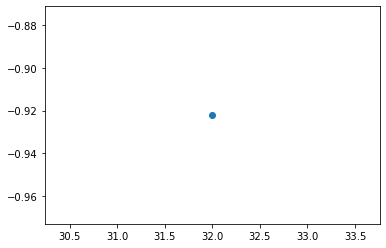

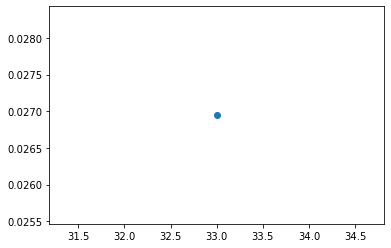

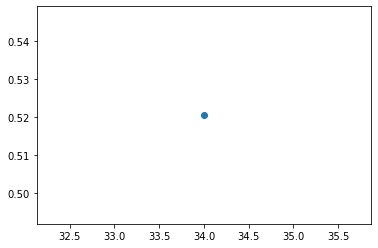

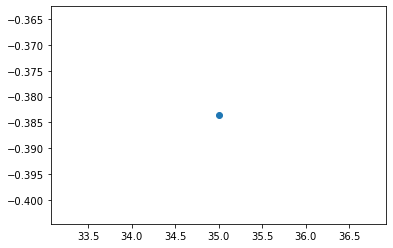

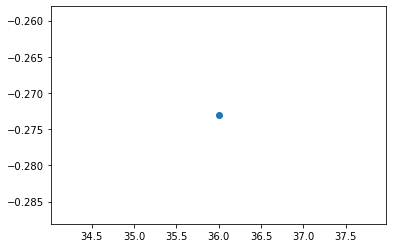

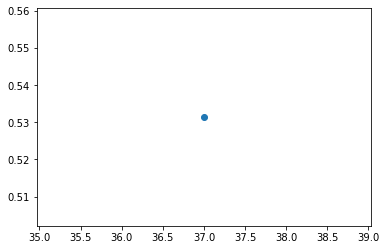

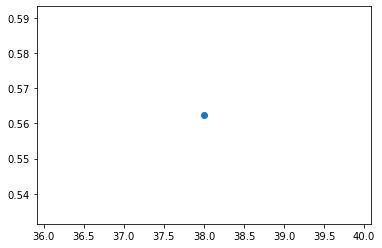

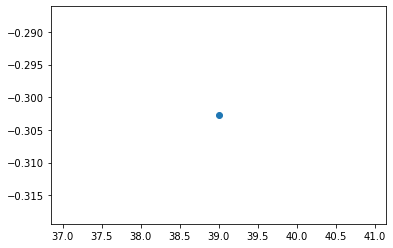

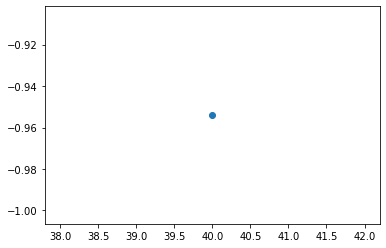

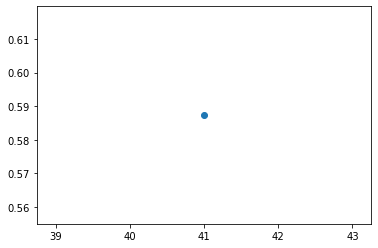

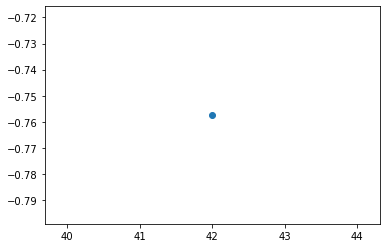

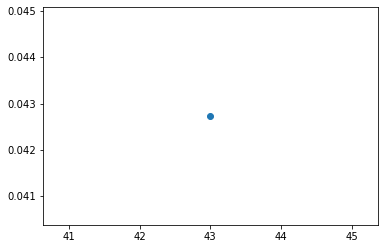

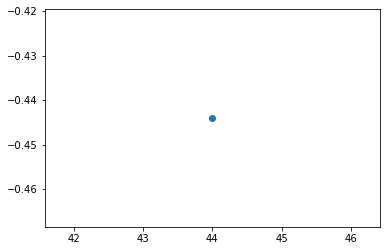

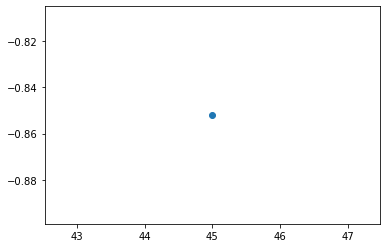

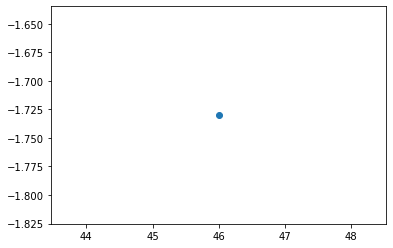

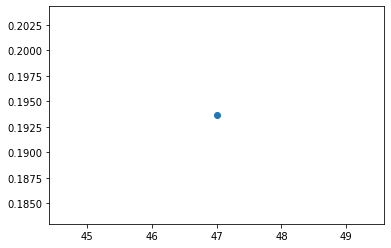

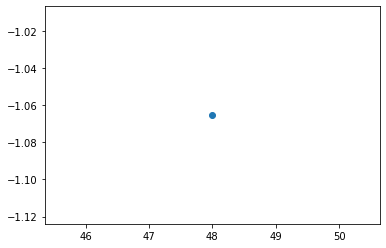

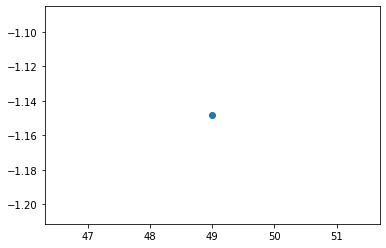

In [6]:
for i in range(50):
    y = stats.norm.rvs(0, 1)
    plt.scatter(i, y)
    plt.pause(0.004)

plt.show()

In [57]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Thu Jul 28 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.3.0

aesara: 2.6.6
aeppl : 0.0.31

pandas    : 1.4.2
xarray    : 0.20.1
matplotlib: 3.5.1
pymc      : 4.0.0
seaborn   : 0.11.2
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
numpy     : 1.22.4
arviz     : 0.12.1

Watermark: 2.3.1

